In [3]:
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torch import nn
from sklearn.metrics import f1_score
from tqdm import tqdm
from lion_pytorch import Lion

In [4]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import torch.optim as optim
from glob import glob
from tqdm import tqdm
import random
from torch.utils.data import DataLoader

In [2]:
!pip install lion_pytorch

In [5]:
import os
import plotly.express as px

In [6]:
folder_path = '/content/drive/MyDrive/DPL302m_Project/train/dừa non'
files = os.listdir(folder_path)
num_files = len(files)
print(f"Number of files in the folder: {num_files}")

Number of files in the folder: 805


In [7]:
# Set up transforms and datasets
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [8]:
train_data = torchvision.datasets.ImageFolder(
    root=r'/content/drive/MyDrive/DPL302m_Project/train', transform=train_transforms)
val_data = torchvision.datasets.ImageFolder(
    root=r'/content/drive/MyDrive/DPL302m_Project/val', transform=val_transforms)

In [9]:
num_classes = len(train_data.classes)
classes_name = train_data.classes
classes2idx = train_data.class_to_idx

print(f"Number of classes: {num_classes}")
print(f"Classes names: {classes_name}")
print(f"Labels mapping: {classes2idx}")
print("Number of train: ", len(train_data))
print("Number of val: ", len(val_data))

Number of classes: 4
Classes names: ['dừa già', 'dừa nạo', 'dừa non', 'loại khác']
Labels mapping: {'dừa già': 0, 'dừa nạo': 1, 'dừa non': 2, 'loại khác': 3}
Number of train:  3385
Number of val:  422


run: 100%|██████████| 4/4 [00:00<00:00, 51.07it/s]


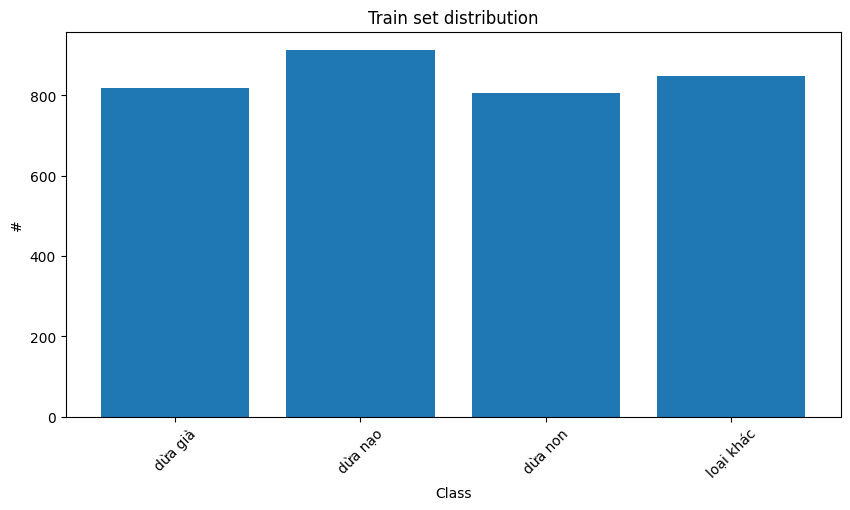

In [10]:
all_class = glob("/content/drive/MyDrive/DPL302m_Project/train/*")
train_class_counts =  {}
for folder_class in tqdm(all_class, desc='run'):
    name = folder_class.split('/')[-1]
    train_class_counts[name] = len(glob(f"{folder_class}/*"))
train_class_counts = dict(sorted(train_class_counts.items(), key=lambda item: item[0]))

plt.figure(figsize=(10, 5))
plt.bar(list(train_class_counts.keys()), list(train_class_counts.values()))
plt.title('Train set distribution')
plt.xlabel('Class')
plt.ylabel('#')
plt.xticks(rotation=45)
plt.show()

In [11]:
# Set up MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)
NUM_CLASSES = 4
model.classifier[1] = nn.Linear(model.last_channel, NUM_CLASSES)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 81.5MB/s]


In [12]:
for param in model.features.parameters():
    param.requires_grad = False

In [13]:
# Print model parameters
print("# Parameters", sum(p.numel() for p in model.parameters()))

# Parameters 2228996


In [14]:
# Set up device and other training parameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 40
BATCH_SIZE = 64

In [15]:
# Create data loaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

In [16]:
# Move model to device
model.to(DEVICE)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [18]:
# Set up loss, optimizer, and filename for saving the model
criterion = nn.CrossEntropyLoss()
optimizer = Lion(model.parameters(), lr=1e-4, weight_decay=1e-2)
MODEL_SAVE_PATH = 'MobileNetV2.pt'

In [19]:
# Set up early stopping parameters
PATIENCE = 5
BEST_VALIDATION_LOSS = float('inf')
NO_IMPROVEMENT_COUNT = 0

In [20]:
# Lists to store training and testing metrics
LOSS_TRAIN = []
LOSS_TEST = []
F1_TRAIN = []
F1_TEST = []

# Training loop
for EPOCH in range(EPOCHS):
    model.train()
    RUNNING_LOSS = 0.0
    PREDICTIONS_TRAIN = []
    TRUE_LABELS_TRAIN = []

    for I, DATA in tqdm(enumerate(train_loader), desc='train'):
        INPUTS, LABELS = DATA
        INPUTS = INPUTS.to(DEVICE)
        LABELS = LABELS.to(DEVICE)
        optimizer.zero_grad()
        OUTPUTS = model(INPUTS)
        LOSS = criterion(OUTPUTS, LABELS)
        LOSS.backward()
        optimizer.step()
        RUNNING_LOSS += LOSS.item()
        _, PREDICTED = torch.max(OUTPUTS.data, 1)
        PREDICTIONS_TRAIN.extend(PREDICTED.tolist())
        TRUE_LABELS_TRAIN.extend(LABELS.tolist())

    TRAIN_LOSS = RUNNING_LOSS / len(train_loader)
    TRAIN_F1 = f1_score(TRUE_LABELS_TRAIN, PREDICTIONS_TRAIN, average='weighted')

    LOSS_TRAIN.append(TRAIN_LOSS)
    F1_TRAIN.append(TRAIN_F1)

    model.eval()
    TEST_LOSS_VAL = 0.0
    PREDICTIONS = []
    TRUE_LABELS = []

    with torch.no_grad():
        for DATA in test_loader:
            INPUTS, LABELS = DATA
            INPUTS = INPUTS.to(DEVICE)
            LABELS = LABELS.to(DEVICE)
            OUTPUTS = model(INPUTS)
            LOSS = criterion(OUTPUTS, LABELS)
            TEST_LOSS_VAL += LOSS.item()
            _, PREDICTED = torch.max(OUTPUTS.data, 1)
            PREDICTIONS.extend(PREDICTED.tolist())
            TRUE_LABELS.extend(LABELS.tolist())

    TEST_LOSS_VAL /= len(test_loader)
    TEST_F1_VAL = f1_score(TRUE_LABELS, PREDICTIONS, average='weighted')

    LOSS_TEST.append(TEST_LOSS_VAL)
    F1_TEST.append(TEST_F1_VAL)

    print(f'Train Loss: {TRAIN_LOSS:.4f} - Train F1: {TRAIN_F1:.4f}')
    print(f'Epoch [{EPOCH + 1}/{EPOCHS}]  - Train Loss: {TRAIN_LOSS:.4f} - Train F1: {TRAIN_F1:.4f} - Test Loss: {TEST_LOSS_VAL:.4f} - Test F1: {TEST_F1_VAL:.4f}')

    if TEST_LOSS_VAL < BEST_VALIDATION_LOSS:
        BEST_VALIDATION_LOSS = TEST_LOSS_VAL
        NO_IMPROVEMENT_COUNT = 0
        torch.save(model.state_dict(), MODEL_SAVE_PATH)

    else:
        NO_IMPROVEMENT_COUNT += 1

    if NO_IMPROVEMENT_COUNT >= PATIENCE:
        print(f'Early stopping after {EPOCH + 1} epochs due to no improvement in validation loss.')
        break

print('Finished Training')

train: 53it [12:15, 13.88s/it]


Train Loss: 1.0514 - Train F1: 0.6353


train: 53it [01:44,  1.97s/it]


Train Loss: 0.5668 - Train F1: 0.9123


train: 53it [01:45,  1.98s/it]


Train Loss: 0.3302 - Train F1: 0.9353


train: 53it [01:46,  2.00s/it]


Train Loss: 0.2227 - Train F1: 0.9444


train: 53it [01:54,  2.17s/it]


Train Loss: 0.1582 - Train F1: 0.9526


train: 53it [01:46,  2.01s/it]


Train Loss: 0.1341 - Train F1: 0.9552


train: 53it [01:43,  1.95s/it]


Train Loss: 0.1110 - Train F1: 0.9613


train: 53it [01:42,  1.93s/it]


Train Loss: 0.0958 - Train F1: 0.9698


train: 53it [01:50,  2.09s/it]


Train Loss: 0.0741 - Train F1: 0.9760


train: 53it [01:48,  2.05s/it]


Train Loss: 0.0660 - Train F1: 0.9775


train: 53it [01:48,  2.04s/it]


Train Loss: 0.0627 - Train F1: 0.9817


train: 53it [01:47,  2.02s/it]


Train Loss: 0.0606 - Train F1: 0.9766


train: 53it [01:49,  2.06s/it]


Train Loss: 0.0501 - Train F1: 0.9829


train: 53it [01:49,  2.07s/it]


Train Loss: 0.0502 - Train F1: 0.9846


train: 53it [01:47,  2.03s/it]


Train Loss: 0.0477 - Train F1: 0.9837


train: 53it [01:52,  2.12s/it]


Train Loss: 0.0398 - Train F1: 0.9879


train: 53it [01:48,  2.04s/it]


Train Loss: 0.0400 - Train F1: 0.9873


train: 53it [01:49,  2.07s/it]


Train Loss: 0.0358 - Train F1: 0.9894


train: 53it [01:49,  2.07s/it]


Train Loss: 0.0365 - Train F1: 0.9882


train: 53it [01:47,  2.02s/it]


Train Loss: 0.0290 - Train F1: 0.9911


train: 53it [01:47,  2.02s/it]


Train Loss: 0.0322 - Train F1: 0.9903
Early stopping after 21 epochs due to no improvement in validation loss.
Finished Training


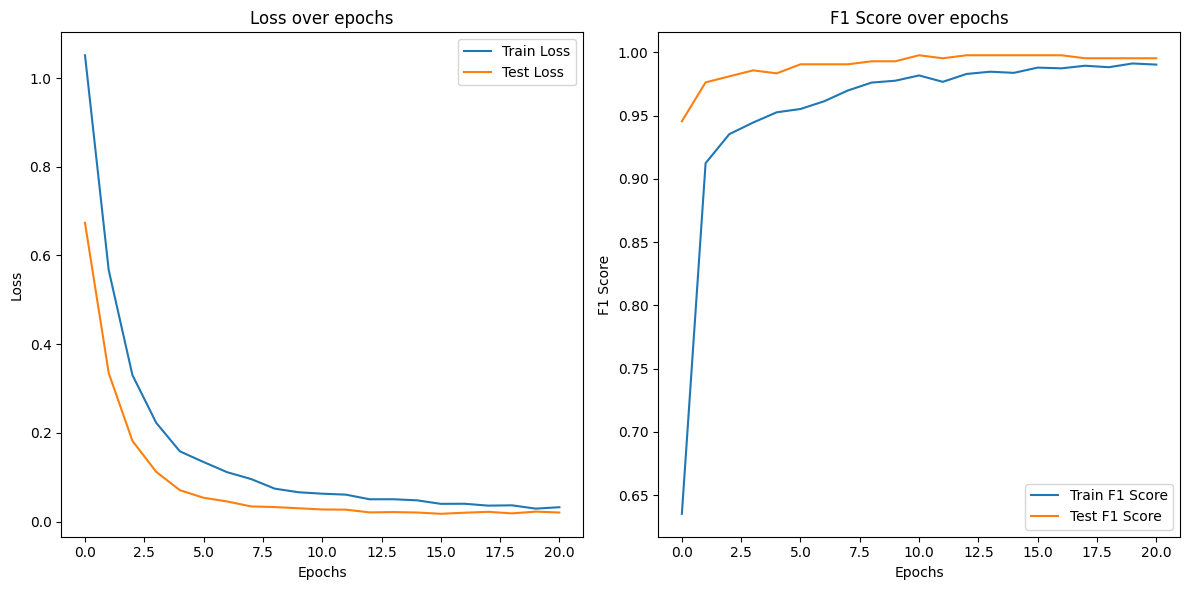

In [21]:
# Plotting the metrics
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(LOSS_TRAIN, label='Train Loss')
plt.plot(LOSS_TEST, label='Test Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(F1_TRAIN, label='Train F1 Score')
plt.plot(F1_TEST, label='Test F1 Score')
plt.title('F1 Score over epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
print( F1_TEST)

[0.9454538633982749, 0.9762192296339457, 0.9809538687729693, 0.9856924536431514, 0.9833420934486113, 0.9904937731340306, 0.9904937731340306, 0.9904937731340306, 0.9928721709850816, 0.9928721709850816, 0.9976308918986219, 0.9952510352718211, 0.9976308918986219, 0.9976308918986219, 0.9976308918986219, 0.9976308918986219, 0.9976308918986219, 0.995261338670657, 0.995261338670657, 0.9952510352718211, 0.995261338670657]


In [22]:
from PIL import Image

In [24]:
model = models.mobilenet_v2(num_classes=4)
model.load_state_dict(torch.load("/content/MobileNetV2.pt"))
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [25]:
# Load your image and preprocess it
image_path = '/content/drive/MyDrive/DPL302m_Project/test/loại khác/Strawberry (1867).jpeg'
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_data = preprocess(image).unsqueeze(0)  # Add a batch dimension

# Perform inference
with torch.no_grad():
    output = model(input_data)

# Post-process the output to get class probabilities
probabilities = torch.softmax(output, dim=1)

# Get the predicted class (class with the highest probability)
predicted_class = torch.argmax(probabilities, dim=1)

# Print or use the predicted class
print("Predicted Class:", predicted_class.item())

Predicted Class: 3


tensor([[2.4658e-08, 5.7300e-05, 2.2990e-06, 9.9994e-01]])


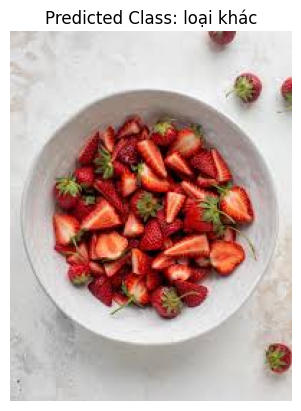

In [46]:
import matplotlib.pyplot as plt

# Define a list of class names in the order they correspond to the model's output
class_names = ["dừa già", "dừa nạo", "dừa non","loại khác"]

# Load your image and preprocess it
image_path = '/content/drive/MyDrive/DPL302m_Project/test/loại khác/Strawberry (1872).jpeg'
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_data = preprocess(image).unsqueeze(0)  # Add a batch dimension

# Perform inference
with torch.no_grad():
    output = model(input_data)

# Post-process the output to get class probabilities
probabilities = torch.softmax(output, dim=1)
print(probabilities)
# Get the predicted class (class with the highest probability)
predicted_class = torch.argmax(probabilities, dim=1)

# Use the predicted class to get the class name
predicted_class_index = predicted_class.item()
predicted_class_name = class_names[predicted_class_index]

# Display the image with the predicted class name
plt.imshow(image)
plt.title("Predicted Class: " + predicted_class_name)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()